# Laboratorio 4
### Clasificación de Imágenes con CNN (CIFAR-10)

---- 

Nancy Mazariegos 22513


Santiago Pereira 22318


----

### Parte 1 - Preparación del Conjunto de Datos

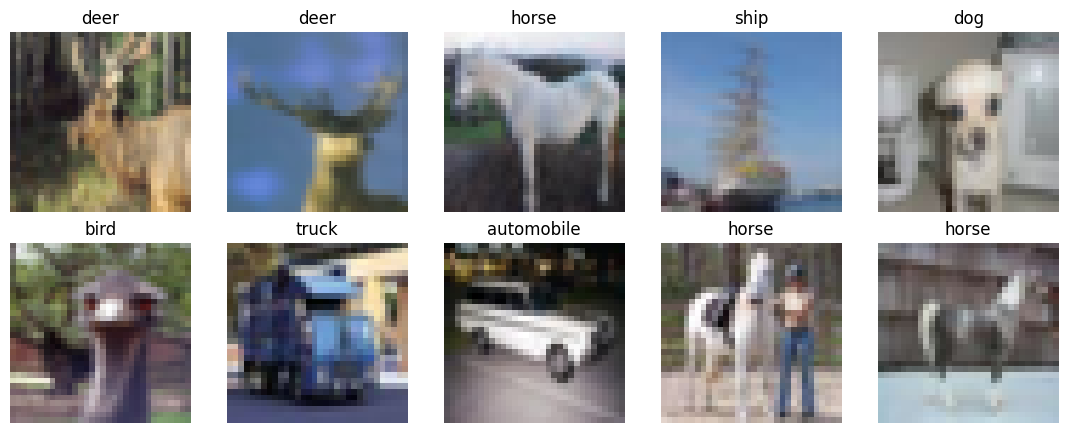

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

val_ratio = 0.1
num_val = int(len(x_train) * val_ratio)
x_val, y_val = x_train[:num_val], y_train[:num_val]
x_train, y_train = x_train[num_val:], y_train[num_val:]

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

def show_samples(images, labels, rows=2, cols=5, class_names=class_names, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(images), size=rows*cols, replace=False)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx])
        plt.title(class_names[int(labels[idx][0])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(x_train, y_train, rows=2, cols=5)


### Parte 2 - Modelo Base ANN

In [ ]:
import time
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)

ann = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Flatten(),                             
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

start = time.time()
hist_ann = ann.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early],
    verbose=1
)
train_time_s = time.time() - start

print(f"Tiempo de entrenamiento ANN: {train_time_s:.1f} s")

test_loss, test_acc = ann.evaluate(x_test, y_test, verbose=0)
print(f"ANN - Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


In [ ]:
import matplotlib.pyplot as plt

def plot_history(h, title_prefix="ANN"):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title(f"{title_prefix} - Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()

    # Pérdida
    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title(f"{title_prefix} - Loss")
    plt.legend(); plt.tight_layout(); plt.show()

plot_history(hist_ann, "ANN")
